<a href="https://colab.research.google.com/github/dorahs71/ml-course/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# “What sorts of people were more likely to survive?”

using passenger data (ie name, age, gender, socio-economic class, etc)

In [74]:
import urllib.request as req
url = "https://github.com/Elwing-Chou/ximen0624/raw/main/titanic/train.csv"
req.urlretrieve(url, "train.csv")

url = "https://github.com/Elwing-Chou/ximen0624/raw/main/titanic/test.csv"
req.urlretrieve(url, "test.csv")

('test.csv', <http.client.HTTPMessage at 0x782d277368f0>)

In [75]:
import pandas as pd
train = pd.read_csv("train.csv", encoding="utf-8") #永遠都用utf-8
test = pd.read_csv("test.csv", encoding="utf-8")

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# 資料預處理
- 不能有空資料，要填缺失值
- 把不需要的欄位去掉：PassengerId, Survived
- 一次處理完 train & test
- 好好理解自己的資料，例如：車票號碼，可以反映有哪些人是一起買票的，他們可能是朋友、情人、其他親密關係
- Cabin 雖然很多沒有資料，但因為可以反映船上的人際和財務能力，還是納入考量(只先抓前綴字母)
- Embarked：上船的地點



In [76]:
datas = pd.concat([train, test], axis=0) #用 axis=0 來合併 item 數量
datas = datas.drop(["PassengerId", "Survived"], axis=1) #用 axis=1 來 drop 欄位

In [77]:
# 語法教學
# Everything is an object: 任何東西皆具有型態，每個型態具有其獨特操作
# 型態: dict, 操作： [key]
# 功能也是如此，型態：int -> 只是步驟, 操作: (4.2) -> 加小括號表示真的執行

# def test(mode):
#   if mode is True:
#     return int
#   else:
#     return round

# test(False)(10000.6) -> 10001
# test(True)(10000.6) -> 10000


In [78]:
# apply: 轉換
def func(a):
  return (a ** 2) * 10

s = pd.Series([1, 2, 3, 4])
s.apply(func) # = (s ** 2) * 10


0     10
1     40
2     90
3    160
dtype: int64

In [79]:
def func(s):
  return (s.split(".")[0]
          .split(",")[-1]
          .strip())
datas["Name"] = datas["Name"].apply(func)

datas["Name"]

0          Mr
1         Mrs
2        Miss
3         Mrs
4          Mr
        ...  
413        Mr
414      Dona
415        Mr
416        Mr
417    Master
Name: Name, Length: 1309, dtype: object

In [80]:
def func(s):
  if pd.isna(s):
    return s
  else:
    return s[0]

datas["Cabin"] = datas["Cabin"].apply(func)

datas["Cabin"]

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
413    NaN
414      C
415    NaN
416    NaN
417    NaN
Name: Cabin, Length: 1309, dtype: object

In [81]:
# datas["Name"].value_counts()

In [82]:
counts = datas["Ticket"].value_counts()

def func(t):
  if pd.isna(t):
    return t
  else:
    return counts[t]

datas["Ticket"] = datas["Ticket"].apply(func)

datas["Ticket"]

0      1
1      2
2      1
3      2
4      1
      ..
413    1
414    3
415    1
416    1
417    3
Name: Ticket, Length: 1309, dtype: int64

# 欄位分別
1. 類別：固定幾種，（Pclass, Name, Sex, Cabin, Embarked）

2. 數值：連續型，(Age, SibSp, Parch Ticket#, Fare)

# 資料預處理
1. 填缺失值：
- a 類別：補最常出現的類別(眾數)
- b 數值：補中位數，表示所有資料中有一半大於，一半小於

2. One-Hot:調整「類別資料」


P.S 老師補充了「偏度」現在的算法，已經和以前的統計學概念不一樣了，以前會說，右偏的話，中位數小於平均數，但其實這兩個的數學意義不同，也沒有這個數學關係

# 要當個懷疑論者


In [83]:
datas.isna() #True 表空值

s = datas.isna().sum() #表該欄位是空的的總數

# 篩選 Series[跟你 Series 比數一樣多的 True/False]

fil = s > 0

s[fil]

Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [84]:
# 類別型：補最常出現的

most = datas["Embarked"].value_counts().idxmax() #S:914 最多，取最大值 index

datas["Embarked"] = datas["Embarked"].fillna(most)

In [85]:
# 數值型：補中位數

s = datas.dtypes
fil = s != "object"
num_index = s[fil].drop("Pclass").index
med = datas[num_index].median()

datas = datas.fillna(med)

# Pclass 雖然資料型別是數字，但以現時邏輯來看，算是 “類別” 喔！如果他有缺，應該要補成最常出現的

In [86]:
datas.isna() #True 表空值

s = datas.isna().sum() #表該欄位是空的的總數

# 篩選 Series[跟你 Series 比數一樣多的 True/False]

fil = s > 0

s[fil]

Cabin    1014
dtype: int64

# 資料是否可以合併

Miss 和 Lady 可能都是單身女性<br>
但 Miss 可能是美國單身<br>
Lady 可能是英國單身<br>
不同國別可能也會有影響<br>
而且 Lady 也只有一個，對最後結果影響不大

One-Hot encoding:

- Name : 會篩選出現率比較少的(為了美觀)
- Sex : 因為是二值型，不做 One-Hot 也可以，也可直接換成 0/1
- Cabin : 使用 000 來當作不知道 (順便補缺失資料)
在實務上，不會因為欄位彼此的關係性，而影響結果，所以不會因此丟掉欄位
- Pclass : 雖他是類別型欄位，但這類別說他有大小關係又沒問題，所以你可以選擇做也可不做，但做了的話，做會正確率高一點(因為老師試過了)

#先補中位數，再做 One-Hot encoding

In [87]:
reserved = datas["Name"].value_counts().index[:4]

def func(n):
  if n in reserved:
    return n
  else:
    return None

datas["Name"] = datas["Name"].apply(func)


In [88]:
import pandas as pd
pd.set_option('display.max_columns', 500)


datas = pd.get_dummies(datas) #dummies 處理冗余，並將字串的類別展開成多欄位

#因 Pclass 是數值資料，故不會自動做 One-Hot，所以要指定他做

datas = pd.get_dummies(datas, columns=["Pclass"])

In [89]:
# Step 3. 這個其實是最後才做的

datas["Family"] = datas["SibSp"] + datas["Parch"]

# kNearestNeighbors -> KNN 演算法，看最近的幾個鄰居，多的就以他的類別 or 平均數為主
# 算距離的時候，單位很重要(ex. 歲數 v.s. SibSp v.s. Fare)
# 把單位一致化 => Scaling，把所有欄位變成 0 ~ 1

# MinMaxScaling

# Age (x) => x' = x-min/max-min


In [90]:
from sklearn.preprocessing import MinMaxScaler
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

#訓：fit + transform
#測：transform

scaler = MinMaxScaler()
datas_scaled = pd.DataFrame(scaler.fit_transform(datas),columns=datas.columns)

In [91]:
# Demo: pandas取列

d = pd.DataFrame([
    ["a", "b"],
    ["c", "d"],
    ["e", "f"]
], index=[0,0,1])

#loc：是看列標籤取列， iloc：是看第幾列取列！！
d.iloc[2]

0    e
1    f
Name: 1, dtype: object

In [92]:
x = datas[:len(train)]
x_predict = datas[len(train):]
x_scaled = datas_scaled[:len(train)]
x_predict_scaled = datas_scaled[len(train):]
y = train["Survived"]

In [93]:
# 之前我們是把 x -> x_train(90) 和 x_test(10)
# 如果要消除隨機性的話，就是多做幾次，將結果再取平均 -> Cross Validation

import numpy as np
from sklearn.model_selection import cross_val_score
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#cross-val-score
# cv 指切幾分

from sklearn.neighbors import KNeighborsClassifier

for n in range(2, 30):
  clf = KNeighborsClassifier(n_neighbors = n) #n_neighbors 可調參
  scores  = cross_val_score(clf, x_scaled, y, cv=10)
  avg = np.average(scores) #大家做出來的結果會是一樣的
  print(n, ":", avg)

# n = 7 的結果最高，不過在 kaggle 比賽的資料，用 11 更高

2 : 0.7901747815230962
3 : 0.8193757802746566
4 : 0.8058801498127341
5 : 0.8170786516853932
6 : 0.8227091136079899
7 : 0.832796504369538
8 : 0.8136828963795256
9 : 0.8125842696629213
10 : 0.8058676654182271
11 : 0.818214731585518
12 : 0.8069787765293384
13 : 0.8137203495630463
14 : 0.8125842696629213
15 : 0.8227215980024967
16 : 0.8137203495630463
17 : 0.8193508114856429
18 : 0.8137203495630461
19 : 0.8137203495630463
20 : 0.8170536828963794
21 : 0.8136953807740325
22 : 0.8148064918851435
23 : 0.8148064918851435
24 : 0.8147940074906368
25 : 0.8136828963795256
26 : 0.8091885143570536
27 : 0.8058676654182273
28 : 0.8069538077403247
29 : 0.8058426966292135


In [94]:
clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(x_scaled, y)
pre = clf.predict(x_predict_scaled)
result = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": pre
})

result.to_csv("titanic_knn.csv", encoding ="utf-8", index=False)



# Bagging
- Random Forest：就是一個完整的演算法
每一筆資料，就是一顆決策樹

# Boosting

In [95]:
# 改用GridSearchCV來自動幫你搜索
from sklearn.model_selection import GridSearchCV
clf = KNeighborsClassifier()
params = {
    "n_neighbors":range(2, 30)
}
cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
cv.fit(x_scaled, y)
print(cv.best_score_)
print(cv.best_params_)

0.832796504369538
{'n_neighbors': 7}


In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#https://scikit-learn.org/stable/api/sklearn.ensemble.html

#clf = KNeighborsClassifier()
clf = RandomForestClassifier()

params = {
    "max_depth": range(2,8),
    "n_estimators": range(21, 40, 2) #從 21 開始，到 40，每兩個一跳，21, 23,25,27....
    #設定幾顆決策樹 -> 需要多少人投票？ 最佳解不一定是越多人越好
}

from sklearn.model_selection import GridSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

cv = GridSearchCV(clf, params, cv=10, n_jobs=1) #相當於之前用 for loop 決定參數
cv.fit(x, y)
print(cv.best_score_)
print(cv.best_params_)

0.842896379525593
{'max_depth': 7, 'n_estimators': 29}


In [97]:
# 你做完 GridSearch 可以直接拿
clf = cv.best_estimator_

[Text(0.5, 0.875, 'Pclass_1 <= 0.5\ngini = 0.477\nsamples = 541\nvalue = [541, 350]\nclass = Victim'),
 Text(0.25, 0.625, 'Name_Miss <= 0.5\ngini = 0.44\nsamples = 400\nvalue = [442, 214]\nclass = Victim'),
 Text(0.125, 0.375, 'Sex_female <= 0.5\ngini = 0.359\nsamples = 314\nvalue = [385, 118]\nclass = Victim'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'SibSp <= 2.5\ngini = 0.468\nsamples = 86\nvalue = [57, 96]\nclass = Survivor'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Embarked_S <= 0.5\ngini = 0.488\nsamples = 141\nvalue = [99, 136]\nclass = Survivor'),
 Text(0.625, 0.375, 'SibSp <= 0.5\ngini = 0.462\nsamples = 54\nvalue = [33, 58]\nclass = Survivor'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Sex_female <= 0.5\ngini = 0.497\nsamples = 87\nvalue = [66, 78]\nclass = Survivor'),
 Text(0.8125, 0.125, '\n  (...)  \n')

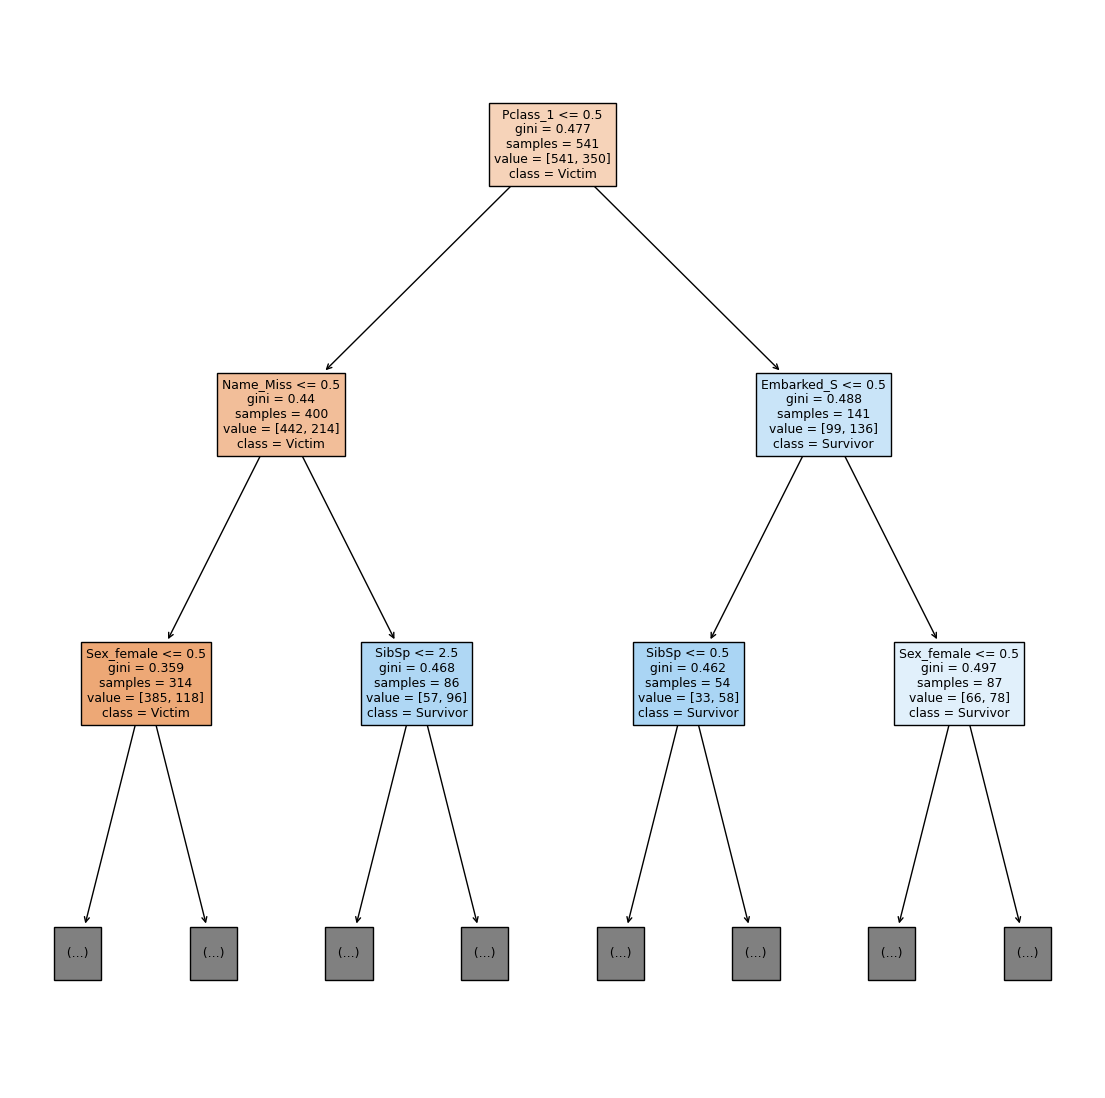

In [98]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=[14, 14])
# estimators_裡存放著他的每一個決策樹
plot_tree(clf.estimators_[2],
     feature_names=x.columns,
     class_names=["Victim", "Survivor"],
     filled=True,
     max_depth=2)


In [100]:
imp = clf.feature_importances_
pd.Series(imp, index=x.columns).sort_values(ascending=False)
#取得的百分比，就表示影響生還機率最大的要素，從高排到低
#看得出來性別就佔了考量要素的 30%

Sex_male       0.184709
Sex_female     0.145872
Name_Mr        0.126274
Fare           0.095393
Age            0.075028
Family         0.054091
Pclass_3       0.053933
Ticket         0.048067
Pclass_1       0.035089
Name_Miss      0.030698
SibSp          0.028024
Pclass_2       0.016879
Parch          0.014919
Cabin_E        0.014776
Name_Mrs       0.014342
Name_Master    0.013041
Embarked_S     0.010821
Embarked_C     0.009979
Embarked_Q     0.008112
Cabin_D        0.006092
Cabin_B        0.005270
Cabin_C        0.004483
Cabin_A        0.002539
Cabin_G        0.001177
Cabin_F        0.000363
Cabin_T        0.000028
dtype: float64

<Axes: xlabel='Sex', ylabel='count'>

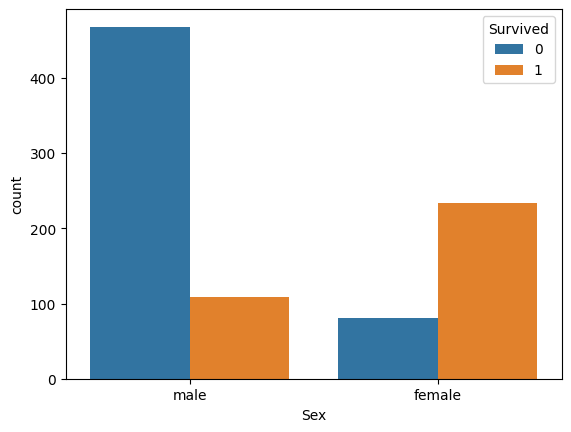

In [102]:
import seaborn as sns
# seaborn 的 hue 參數，就代表多一個維度 or 特徵
sns.countplot(x=train["Sex"], hue=train["Survived"])

# 活著的男生又是為何活著咧？


In [105]:
fil = (train["Sex"] == "male") & (train["Survived"] == 1)
train[fil].describe() # 找出了活著的 109 個男性

# std: 標準差較小的，SibSp, Parch 可以優先考量為原因，但 SibSp, Parch 各自平均數為 0.5 ，加起來為 1，所以這些活著的男生，大概帶了 0.6 ~ 1.4 的人上船
# 另外用 tran.describe() 來比較整體和活著的男性的差異，發現差異不大，所以可能 SibSp, Parch 不是最主要的原因，需再更深入探究

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,109.000000,109.0,109.000000,93.000000,109.000000,109.000000,109.000000
mean,475.724771,1.0,2.018349,27.276022,0.385321,0.357798,40.821484
std,244.717482,0.0,0.922774,16.504803,0.636952,0.645826,71.355967
min,18.000000,1.0,1.000000,0.420000,0.000000,0.000000,0.000000
25%,272.000000,1.0,1.000000,18.000000,0.000000,0.000000,9.500000
50%,508.000000,1.0,2.000000,28.000000,0.000000,0.000000,26.287500
75%,680.000000,1.0,3.000000,36.000000,1.000000,1.000000,39.000000
max,890.000000,1.0,3.000000,80.000000,4.000000,2.000000,512.329200


#軸 : axis

#軸的標籤： label

#圖示： legend

#軸上的刻度： ticks

#標題：title

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '(0.34, 8.378]'),
  Text(1, 0, '(8.378, 16.336]'),
  Text(2, 0, '(16.336, 24.294]'),
  Text(3, 0, '(24.294, 32.252]'),
  Text(4, 0, '(32.252, 40.21]'),
  Text(5, 0, '(40.21, 48.168]'),
  Text(6, 0, '(48.168, 56.126]'),
  Text(7, 0, '(56.126, 64.084]'),
  Text(8, 0, '(64.084, 72.042]'),
  Text(9, 0, '(72.042, 80.0]')])

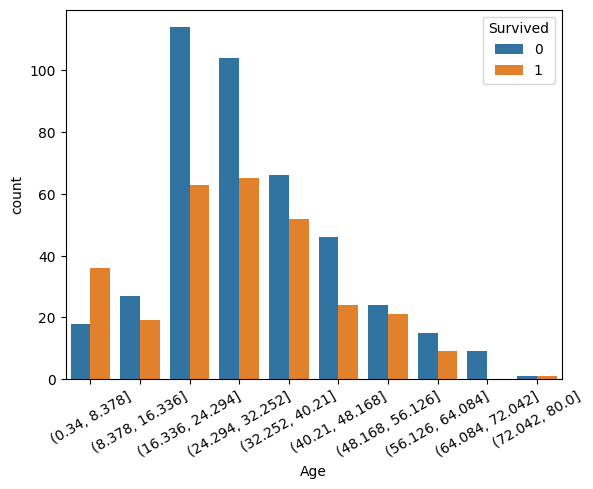

In [108]:
c = pd.cut(train["Age"], bins=10) #切出年齡區間
sns.countplot(x=c, hue=train["Survived"])
plt.xticks(rotation=30)

In [110]:
fil = (train["Age"] <=1) & (train["Survived"] == 0)
train[fil]



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
164,165,0,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '(-0.512, 51.233]'),
  Text(1, 0, '(51.233, 102.466]'),
  Text(2, 0, '(102.466, 153.699]'),
  Text(3, 0, '(153.699, 204.932]'),
  Text(4, 0, '(204.932, 256.165]'),
  Text(5, 0, '(256.165, 307.398]'),
  Text(6, 0, '(307.398, 358.63]'),
  Text(7, 0, '(358.63, 409.863]'),
  Text(8, 0, '(409.863, 461.096]'),
  Text(9, 0, '(461.096, 512.329]')])

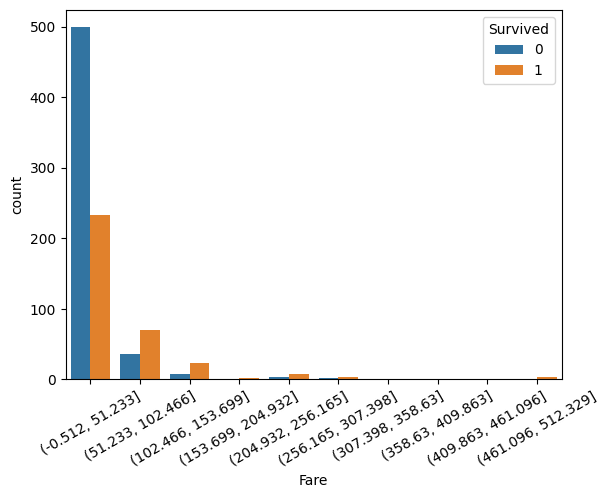

In [111]:
c = pd.cut(train["Fare"], bins=10)
sns.countplot(x=c, hue=train["Survived"])
plt.xticks(rotation=30)
